# Create a sklearn decision tree

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU
from keras.utils import to_categorical
from sklearn.metrics import jaccard_score
from nltk.translate.bleu_score import sentence_bleu
import distance

Using TensorFlow backend.


## Loading iris dataset

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Train sklearn decision tree

In [3]:
clf = DecisionTreeClassifier(random_state=0)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.6, shuffle=True)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

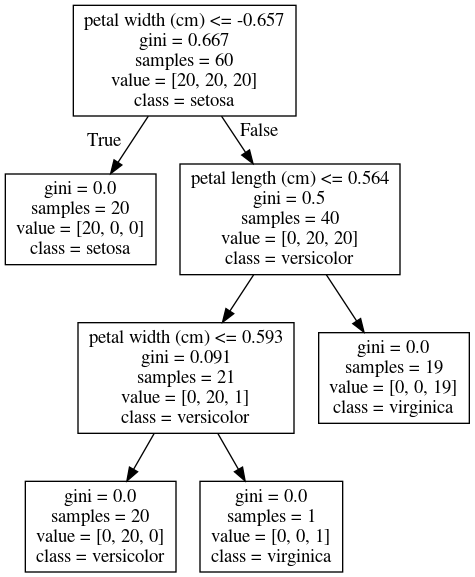

In [4]:
from IPython.display import Image  
from sklearn import tree
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names)

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

Listing out the decision nodes, it's corresponding features and cutpoints. Here, the negative value represents a terminating node.

In [5]:
print('left --    ',clf.tree_.children_left)
print('right --   ',clf.tree_.children_right)
print('features --',clf.tree_.feature)
print('cutpoints --', np.around(clf.tree_.threshold, 1))

left --     [ 1 -1  3  4 -1 -1 -1]
right --    [ 2 -1  6  5 -1 -1 -1]
features -- [ 3 -2  2  3 -2 -2 -2]
cutpoints -- [-0.7 -2.   0.6  0.6 -2.  -2.  -2. ]


In [6]:
left_nodes = clf.tree_.children_left[clf.tree_.children_left > 0]
right_nodes = clf.tree_.children_right[clf.tree_.children_right > 0]
cutpoints = np.around(clf.tree_.threshold, 1)[np.around(clf.tree_.threshold, 1) > -1]
node_indicator = clf.decision_path(X)

In [7]:
paths_as_int = [] # list of path for each instance in iris dataset. Change to paths_as_int
for i, j in enumerate(X):
    paths_as_int.append(
        node_indicator.indices[node_indicator.indptr[i]:node_indicator.indptr[i+1]])

In [8]:
# Convert path to strings
paths_as_string = np.array([])
decision_features_list = []
cutpoints_list = []
for i, j in enumerate(X):
    path = []
    decision_features = []
    cutpoints = []
    for node in paths_as_int[i]:
        if node == 0:
            decision_features.append(0)
            path.append('S')
            decision_features.append(clf.tree_.feature[node]+1)
            cutpoints.append(np.around(clf.tree_.threshold[node], 1))
        elif node in left_nodes:
            path.append('L')
            if clf.tree_.feature[node] >= 0:
                decision_features.append(clf.tree_.feature[node]+1)
                cutpoints.append(np.around(clf.tree_.threshold[node], 1))
        elif node in right_nodes:
            path.append('R')
            if clf.tree_.feature[node] >= 0:
                decision_features.append(clf.tree_.feature[node]+1)
                cutpoints.append(np.around(clf.tree_.threshold[node], 1))

    path.append('E')
    decision_features = np.array(decision_features)
    cutpoints = np.array(cutpoints)
    path = ' '.join(path)
    paths_as_string = np.append(paths_as_string, path)
    decision_features_list.append(decision_features)
    cutpoints_list.append(cutpoints)

In [9]:
chars = ['S', 'L', 'R', 'E']

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Restructuring dataframe to include corresponding paths, decision_features and cutpoints

In [10]:
Xnew = np.hstack((X, paths_as_string.reshape(-1, 1)))
path_sequence = Xnew[:, 4]
data = pd.DataFrame(Xnew)
data[5] = y
data[6] = np.array(decision_features_list)
data[7] = np.array(cutpoints_list)
df = data.sample(frac=1).reset_index(drop=True)

In [11]:
df.head()

,0,1,2,3,4,5,6,7
0,-1.2641847816287635,-0.1319794793216258,-1.3402265266227635,-1.18381211071744,S L E,0,"[0, 4]",[-0.7]
1,-0.5371775589668552,1.939791417006192,-1.3970639535363667,-1.052179926427139,S L E,0,"[0, 4]",[-0.7]
2,0.310997534138703,-0.1319794793216258,0.4785711346125367,0.2641419164758693,S R L L E,1,"[0, 4, 3, 4]","[-0.7, 0.6, 0.6]"
3,-1.2641847816287635,0.7888075857129598,-1.056039392054748,-1.3154442950077407,S L E,0,"[0, 4]",[-0.7]
4,-0.4160096885232043,-1.0527665443562113,0.3648962807853308,0.0008775478952676988,S R L L E,1,"[0, 4, 3, 4]","[-0.7, 0.6, 0.6]"


## Preparing dataset for training

In [12]:
def get_path_lengths(t): return len(t.split())
paths_lengths = np.array([get_path_lengths(xi) for xi in path_sequence])

# Modified for decision feature prediction

decision_feature_vocab_size = 5
path_vocab_size = 4
label_size = 3
feature_size = 4

paths_maxlen = np.max(paths_lengths)
decision_features_maxlen = paths_maxlen-1

input_path_sequence = []
decision_feature_sequence = []
extended_feature_sequence = []
next_chars = []
next_decision_feature = []
features = []
labels = []

for i in range(0, len(df)):
    # get the feature
    curr_feat = np.array([df.iloc[i, 0:4]])
    curr_path = df.iloc[i, 4].split()
    curr_path_len = len(curr_path)
    curr_label = y[i]
    curr_dec_feat = df.iloc[i, 6]
    for j in range(1, curr_path_len):
        features.append(curr_feat)
        labels.append(curr_label)
        input_path_sequence.append(curr_path[0:j])
        next_chars.append(curr_path[j])
    for k in range(1, len(curr_dec_feat)):
        next_decision_feature.append(curr_dec_feat[k])
        decision_feature_sequence.append(curr_dec_feat[0:k])
    for k in range(0, len(curr_dec_feat)):
        extended_feature_sequence.append(curr_dec_feat[0:k+1])
print('Vectorization...')

x_path = np.zeros((len(input_path_sequence), paths_maxlen, path_vocab_size), dtype=np.bool)x_decision_features = np.zeros((len(decision_feature_sequence), decision_features_maxlen, decision_feature_vocab_size), dtype=np.bool)

path_latent_input = np.zeros((len(input_path_sequence), feature_size), dtype=np.float)

decision_feature_latent_input = np.zeros((len(decision_feature_sequence), feature_size), dtype=np.float)

decoder_input = np.zeros((len(extended_feature_sequence), decision_features_maxlen, decision_feature_vocab_size), dtype=np.bool)

y_path = np.zeros((len(input_path_sequence), path_vocab_size), dtype=np.bool)
y_decision_feature = np.zeros((len(decision_feature_sequence), decision_feature_vocab_size), dtype=np.bool)

for i, sentence in enumerate(input_path_sequence):
    for t, char in enumerate(sentence):
        x_path[i, t, char_indices[char]] = 1
    y_path[i, char_indices[next_chars[i]]] = 1
    path_latent_input[i, :] = features[i]

for i, feat in enumerate(decision_feature_sequence):
    for t, val in enumerate(feat):
        x_decision_features[i, t, val] = 1
    y_decision_feature[i, next_decision_feature[i]] = 1
    decision_feature_latent_input[i, :] = features[i]

for i, feat in enumerate(extended_feature_sequence):
    for t, val in enumerate(feat):
        decoder_input[i, t, val] = 1

Vectorization...


## Defining models

### path_model
1. This RNN model is used to predict the seaquence of paths.  
2. It takes 3 inputs   
  - hidden_state from label_model
  - decoder output from features model
  - vectorized paths
3. The output is a single character of the path

In [15]:
def create_path_model(initialize=True, rnn_cell='gru', latent_dim=5):
    latent_dim = latent_dim

    hidden_state_x = Input(shape=(latent_dim,), name='hidden_x')
    feature_decoder_input = Input(shape=(latent_dim,), name='dec_feat')
    sequence_input = Input(shape=(paths_maxlen, path_vocab_size), name='ip_sent')
    if rnn_cell == 'gru':
        RNN = GRU
    else:
        RNN = LSTM

    decoder = RNN(latent_dim, return_state=False,
                  return_sequences=False, name='gru_sent')
    if initialize:
        decoder_outputs = decoder(sequence_input, initial_state=hidden_state_x)
    else:
        decoder_outputs = decoder(sequence_input)

    merge_layer = concatenate(
        [hidden_state_x, feature_decoder_input, decoder_outputs], name='cat')
    output_chars = Dense(path_vocab_size, activation='softmax', name='op_sent')(merge_layer)
    model = Model([hidden_state_x, feature_decoder_input, sequence_input], output_chars)
    return model

### feature_model
1. This RNN model is used to predict the seaquence of corresponding features.  
2. It takes 2 inputs   
  - hidden_state from label_model
  - vectorized decision features
3. The output is a single decision feature

In [16]:
def create_feature_model(initialize=True, rnn_cell='gru', latent_dim=5):
    latent_dim = latent_dim

    hidden_state_x = Input(shape=(latent_dim,), name='hidden_x')
    decision_feature_input = Input(shape=(decision_features_maxlen, decision_feature_vocab_size), name='ip_seq')
    if rnn_cell == 'gru':
        RNN = GRU
    else:
        RNN = LSTM

    decoder = RNN(latent_dim, return_state=False,
                  return_sequences=False, name='gru_seq')
    if initialize:
        decoder_outputs = decoder(decision_feature_input, initial_state=hidden_state_x)
    else:
        decoder_outputs = decoder(decision_feature_input)

    merge_layer = concatenate([hidden_state_x, decoder_outputs], name='cat')
    output_chars = Dense(decision_feature_vocab_size, activation='softmax', name='op_sent')(merge_layer)
    model = Model([hidden_state_x, decision_feature_input], output_chars)
    return model

### label_model
1. This is a regular mlp model. It is used to predict the labels(flower classification) of iris dataset.  
2. It accepts the four features from iris dataset as input.  
3. The output is the corresponding label.

In [17]:
def create_label_model(feature_size=4, latent_dim=5):
    feature_size = feature_size
    h1_size = latent_dim
    input_x_features = Input(shape=(feature_size,), name='ip_x')
    hidden_state_x1 = Dense(20, activation='tanh',
                            name='hidden_x1')(input_x_features)
    hidden_state_x2 = Dense(20, activation='tanh',
                            name='hidden_x2')(hidden_state_x1)
    hidden_state_x3 = Dense(h1_size, activation='tanh',
                            name='hidden_x3')(hidden_state_x2)
    output_labels = Dense(3, activation='softmax',
                          name='op_x')(hidden_state_x3)
    model = Model(input_x_features, output_labels)
    return model

These methods are used to access the hidden_layer output from label_model and decoder outputs from the RNN models(feature_model and path_model).

In [18]:
def get_hidden_x(x, model, layer_num=3):
    def get_hidden_x_inner(model, layer_num=layer_num):
        return K.function([model.layers[0].input], [model.layers[layer_num].output])
    return get_hidden_x_inner(model, layer_num=layer_num)([x])[0]


def get_decoder_output(x1, x2, model, layer_num=2):
    temp_layer = K.function([model.layers[0].input, model.layers[1].input], [
                            model.layers[layer_num].output])
    return temp_layer([x1, x2])[0]

In [19]:
path_model = create_path_model()
label_model = create_label_model()
feature_model = create_feature_model()

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
y_cat = to_categorical(y)

label_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
label_model_history = label_model.fit(X, y_cat, batch_size=20, epochs=200, verbose=0, shuffle=True, validation_split=0.2)

x_latent = get_hidden_x(decision_feature_latent_input, model=label_model)

feature_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
feature_model.fit([x_latent, x_decision_features], y_decision_feature, batch_size=20, epochs=50, verbose=0, shuffle=True, validation_split=0.2)

x_latent = get_hidden_x(path_latent_input, model=label_model)
feat_dec_output = get_decoder_output(x_latent, decoder_input, feature_model)

path_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
path_model.fit([x_latent, feat_dec_output, x_path], y_path, batch_size=20,
           epochs=200, verbose=0, shuffle=True, validation_split=0.2)

## Inference

In [23]:
def jaccard_score_inconsistent(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)


def get_j_coeff(a, b):
    if len(a) != len(b):
        return jaccard_score_inconsistent(a, b)
    return jaccard_score(a, b, average='micro')

latent_dim = 5
def sample_paths(x, path_model=path_model, label_model=label_model, latent_dim=latent_dim, feature_size=feature_size):
    x_f = x.reshape(1, feature_size)
    token = 'S'
    feat_tok = 0  # Root node
    cont = True
    path = [token]
    feature_list = [feat_tok]
    x_path = np.zeros((1, paths_maxlen, path_vocab_size), dtype=np.bool)
    x_decision_features = np.zeros((1, decision_features_maxlen, decision_feature_vocab_size), dtype=np.bool)
    decoder_input = np.zeros((1, decision_features_maxlen, decision_feature_vocab_size), dtype=np.bool)
    x_latent = get_hidden_x(x_f, model=label_model)
    x_latent = x_latent.reshape(1, latent_dim)
    x_path[0, 0, char_indices[token]] = 1
    x_decision_features[0, 0, feat_tok] = 1
    decoder_input[0, 0, feat_tok] = 1
    pred = label_model.predict(x_f)
    label = [np.argmax(pred[0])]
    index = 1
    while (index < decision_features_maxlen):
        pred_feat = feature_model.predict([x_latent, x_decision_features])
        pred_val = np.argmax(pred_feat[0])
        x_path[0, index, pred_val] = 1
        next_val = pred_val
        feature_list.append(next_val)
        decoder_input[0, index, feature_list[index]] = 1
        index += 1

    feat_decoder = get_decoder_output(x_latent, decoder_input, feature_model)
    index = 1
    while cont & (index < paths_maxlen):
        pred = path_model.predict([x_latent, feat_decoder, x_path])
        char_index = np.argmax(pred[0])
        x_path[0, index, char_index] = 1
        next_char = indices_char[char_index]
        path.append(next_char)
        index += 1
        if next_char == 'E':
            cont = False

    return [path, label, feature_list]

### Running sample inferences

In [24]:
count = []
j_coeff = []
j_coeff_feat = []
l_dist = []
pred_feat_list = []
pred_feat_accuracy = []
bleu_score = []
for i in range(1):
    curr_feat = np.array([df.iloc[i, 0:4]])
    path, label, decision_feature = sample_paths(curr_feat)
    print('actual vs predicted: ', df.iloc[i, 4], ' vs ', ' '.join(
        path), 'labels: ', df.iloc[i, 5], label[0])
    count.append(df.iloc[i, 5] == label[0])
    actual_path = df.iloc[i, 4].split()
    actual_path_tok = [char_indices[char] for char in actual_path]
    pred_path_tok = [char_indices[char] for char in path]
    print('actual_path--', actual_path)
    print('path--', path)
    bleu_score.append(sentence_bleu([actual_path], path))
    j_coeff.append(get_j_coeff(actual_path_tok, pred_path_tok))
    j_coeff_feat.append(get_j_coeff(df.iloc[i, 6], decision_feature))
    l_dist.append(distance.levenshtein(
        df.iloc[i, 4].replace(' ', ''), ''.join(path)))

    print('Actual vs predicted features: ', df.iloc[i, 6], 'vs', decision_feature, '\n')


print('\nLabel accuracy - ', np.mean(count))
print('Path metric (Jaccard) - ', np.mean(j_coeff))
print('Path metric (Levensthein) - ', np.mean(l_dist))
print('Decision feature metric (Jaccard) - ', np.mean(j_coeff_feat))
print('Bleu score of paths - ', np.mean(bleu_score))

IndexError: index 4 is out of bounds for axis 2 with size 4

### Sample output

In [69]:
df.iloc[i, 0:4] ## The iris dataset features

0    1.0380047568006114
1    0.5586108194543131
2    1.1037828306621715
3     1.712095943669179
Name: 0, dtype: object

In [64]:
actual_path

['S', 'R', 'R', 'E']

In [61]:
decision_feature

[0, 3, 3, 3]

In [63]:
label

[2]

In [83]:
print('The predicted label was %s and the path traversed to predict the sample was --' %label)
for i, val in enumerate(actual_path):
    if val not in ('S', 'E'):
        if val == 'R':
            decision = '>'
            cut = cutpoints[right_nodes[i-1] - 1]
        else:
            decision = '<='
            cut = cutpoints[left_nodes[i-1] - 1]
        if i == 0:
            cut = cutpoints[0]
        print('Node %d: Feature %s %s %s %s'%(i, decision_feature[i], decision, cut, val))

The predicted label was [2] and the path traversed to predict the sample was --
Node 1: Feature 3 > 0.7 R
Node 2: Feature 3 > 0.5 R
